In [193]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from IPython.display import display

from sklearn import metrics

In [194]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/transform_hot_full.csv', index_col=0)
#df = pd.read_csv('data/transform_hot_mini.csv', index_col=0)
#df = pd.read_csv('data/test_raw_df.csv', index_col=0)
#df = pd.read_csv('data/transform_hot_full_shrunk.csv', index_col=0)
train_cats(df)
df.head()

,Alterac Pass,Battlefield of Eternity,Blackheart's Bay,Braxis Holdout,Cursed Hollow,Dragon Shire,Garden of Terror,Hanamura Temple,Infernal Shrines,Sky Temple,...,theirs_Valla,theirs_Varian,theirs_Whitemane,theirs_Xul,theirs_Yrel,theirs_Zagara,theirs_Zarya,theirs_Zeratul,theirs_Zul'jin,outcome
0,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


#### Helper Functions

In [195]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
map_names = [n for x, n, in m_names.items()]
map_names_swapped = dict([(value, key) for key, value in m_names.items()])

h_names= pd.read_csv("exports/hero_name_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
hero_names = [n for x, n, in h_names.items()]

In [196]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
#col_names = mns+yhns+thns
col_names = df.loc[:, df.columns != 'outcome'].columns
col_names

Index(['Alterac Pass', 'Battlefield of Eternity', 'Blackheart's Bay',
       'Braxis Holdout', 'Cursed Hollow', 'Dragon Shire', 'Garden of Terror',
       'Hanamura Temple', 'Infernal Shrines', 'Sky Temple',
       ...
       'theirs_Valeera', 'theirs_Valla', 'theirs_Varian', 'theirs_Whitemane',
       'theirs_Xul', 'theirs_Yrel', 'theirs_Zagara', 'theirs_Zarya',
       'theirs_Zeratul', 'theirs_Zul'jin'],
      dtype='object', length=188)

In [197]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def split_random(a, n = 0.5):
    msk = np.random.rand(len(a)) < n
    return a[msk].copy(), a[~msk].copy()

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    row_index = 1
    score_cols = ["rmse_trn","rmse_val","scr_trn","scr_val","oob_score","scr_test"]
    scores_compare = pd.DataFrame(columns = score_cols)
    scores_compare.loc[row_index, "rmse_trn"] = round(rmse(m.predict(X_train), y_train), 3)
    scores_compare.loc[row_index, "rmse_val"] = round(rmse(m.predict(X_valid), y_valid), 3)
    scores_compare.loc[row_index, "scr_trn"] = round(m.score(X_train, y_train), 3)
    scores_compare.loc[row_index, "scr_val"] = round(m.score(X_valid, y_valid), 3)
    if hasattr(m, 'oob_score_'): scores_compare.loc[row_index, "oob_score"] = round(m.oob_score_, 3)
    if X_test is not None: scores_compare.loc[row_index, "scr_test"] = round(m.score(X_test, y_test), 3)
    
    #res = ["rmse_trn:",rmse(m.predict(X_train), y_train), "rmse_val:",rmse(m.predict(X_valid), y_valid),
    #            " scr(trn):",m.score(X_train, y_train), " scr(val):",m.score(X_valid, y_valid)]
    #if hasattr(m, 'oob_score_'): res.append(" oob_score_:",m.oob_score_)
    #if X_test is not None: res.append((" scr(test):",m.score(X_test, y_test)))
    print(scores_compare)

In [198]:
#hero_names = df_mixed['winnerA'].cat.categories
heroes_total = max(hero_names)
#map_names = df_mixed['game_map'].cat.categories

#print([len(df[x].cat.categories) for x in df.columns[1:13]], "  heroes_total =", heroes_total)
print(hero_names[:9], "...")
#df_mixed.dtypes

['Abathur', 'Alarak', 'Alexstrasza', 'Ana', 'Anduin', "Anub'arak", 'Artanis', 'Arthas', 'Auriel'] ...


In [199]:
#clear up memory:
#dates_ordinal_newer = 0
#dates_ordinal = 0
#df = pd.DataFrame()
#df_raw = pd.DataFrame()
#df_standard = pd.DataFrame()
#df_inverted = pd.DataFrame()

Great, shuffling worked. Another problem is the format of the table itself. We are more interested in relations between features more than anything else, therefore let's transform the table into something mode understandable for the Tree type model. For that, the first idea to try - split the features into "multiple-hot" encoding table. Not sure if this is even a thing, but let's try that. A one-hot encoder would give us a great start, so let's use that.

In [200]:
winner_cols = ['winnerA', 'winnerB', 'winnerC', 'winnerD', 'winnerE']
loser_cols = ['loserA', 'loserB', 'loserC', 'loserD', 'loserE']

In [201]:
def hero_one_full(game_map = '', winners = [], losers = []):
    new_row = pd.Series(index = col_names, dtype = 'boolean')
    new_row[:] = False
    for x in hero_names:
        if x in winners:
            new_row['yours_'+x] = True
        if x in losers:
            new_row['theirs_'+x] = True
    new_row[game_map] = True
    return new_row

def hero_hot_mini(game_map = '', winners = [], losers = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = int(map_names_swapped[game_map])
    new_row = new_row.append(pd.Series(game_map_index, index = ['game_map'], dtype = 'int8'))
    return new_row

def hero_one_hot(game_map = '', winners = [], losers = []):
    return hero_one_full(game_map = game_map, winners = winners, losers = losers)

In [202]:
game_map = 'Garden of Terror'
game_type = 'UnrankedDraft'
winners=['Auriel', 'Muradin']
losers=['Illidian', 'Abathur']
row = [hero_one_hot(game_map = game_map, winners = winners, losers=losers)]

## Prepare train and val sets

In [203]:
#need this again for new dataframe, cause we attached strings when transforming
#train_cats(dummies_data)

In [204]:
df_trn, y_trn, nas = proc_df(df, 'outcome')

In [205]:
train_required_ratio = 0.8
n_trn = int(len(df_trn) * train_required_ratio)
X_train, X_valid = split_vals(df_trn, n_trn)

n_tst = int(len(X_train) * train_required_ratio)
X_train, X_test = split_vals(X_train, n_tst)

y_train, y_valid = split_vals(y_trn, n_trn)
y_train, y_test = split_vals(y_train, n_tst)

X_train.shape, X_valid.shape, X_test.shape

((19200, 188), (6000, 188), (4800, 188))

In [206]:
#apply_cats(X_valid, X_train)

Start with simple and stupid

In [207]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 55.4 ms, sys: 3.97 ms, total: 59.4 ms
Wall time: 112 ms
  rmse_trn rmse_val scr_trn scr_val oob_score scr_test
1    0.499      0.5   0.003  -0.002       NaN        0


In [208]:
#draw_tree(m.estimators_[0], df_trn, size = 20, precision=3)
#?draw_tree
#?m.score

things to try:
max_features = 0.5, 'sqrt', 'log2'
leafs = 1, 3, 5, 10, 25, 50, 100...

In [209]:
#m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features = 0.2, n_jobs=-1, oob_score=True) #max_features = 1-0.5-0.2, sqrt are good vals
#%time m.fit(X_train, y_train)
#print_score(m)

Well seems like max_features < 1 are not helping, also subsampling doesnt help either.  Let's get back to base mode, with more estimators.

In [210]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 19.1 s, sys: 12.8 ms, total: 19.1 s
Wall time: 5.36 s
  rmse_trn rmse_val scr_trn scr_val oob_score scr_test
1    0.193    0.508   0.851  -0.031       NaN   -0.033


Would feature importance show hero importance in case if I transformed the table to hero-based?

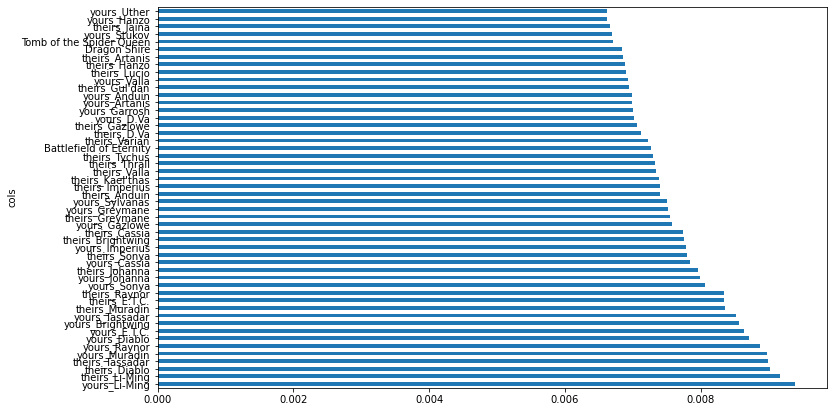

In [211]:
fi = rf_feat_importance(m, df_trn); fi[:10]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:50]);

In [212]:
#to_keep = fi[fi.imp>0.005].cols; len(to_keep)
#df_keep = df_trn[to_keep].copy()
#X_train, X_valid = split_vals(df_keep, n_trn)

checking how correlated the features are:

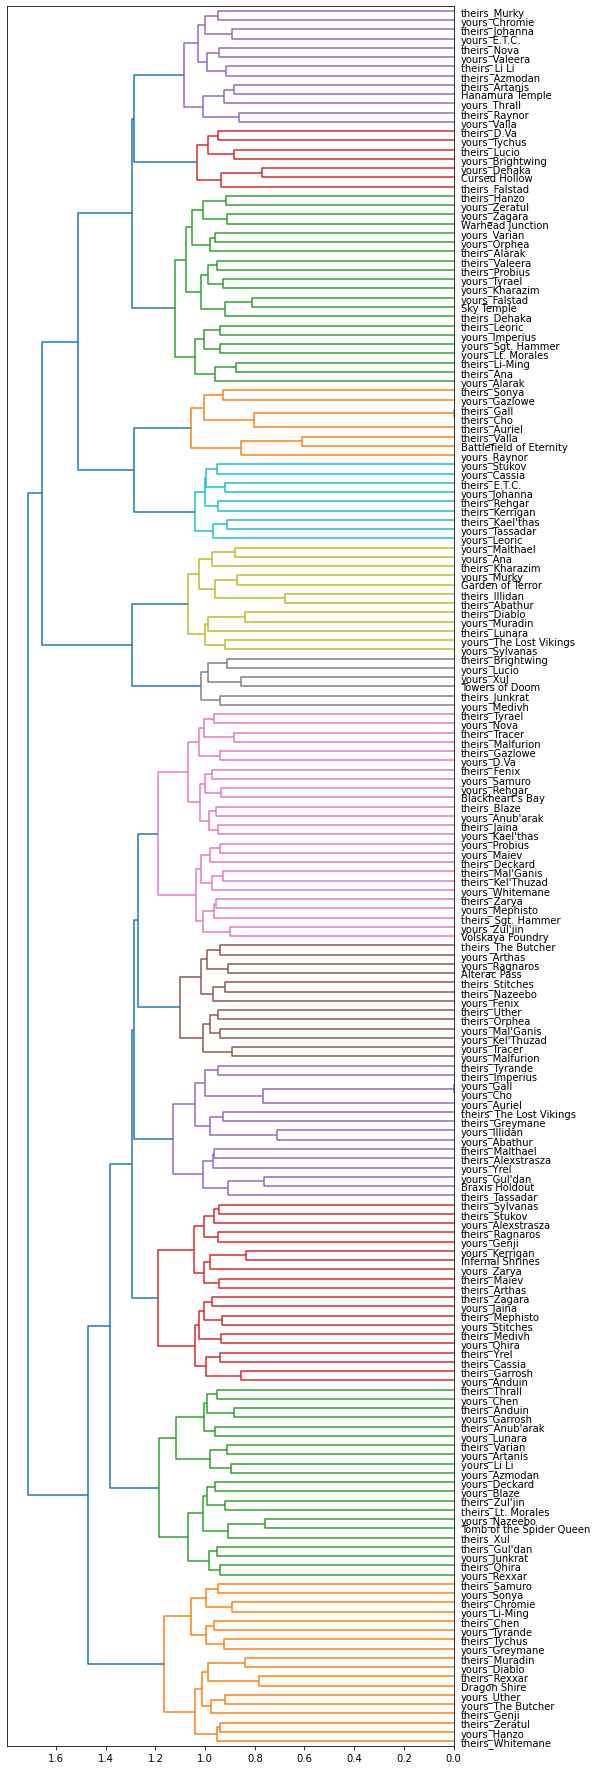

In [213]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_trn).correlation, 3)
corr_condensed = hc.distance.squareform(pow((1-corr), 3))
z = hc.linkage(corr_condensed, method='complete')
fig = plt.figure(figsize=(8,32))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=10)
plt.show()

ggplot(df, aes())+stat_smooth() is a very powerfull graphics lib, coming from R
use get_sample(df, n) to decrease complexity of graph
https://forums.fast.ai/t/unofficial-lesson-4-classnotes/7569
pdp - partial dependence plot library

since the data is patch dependent, it would be better to weight recent matches more whent training. most modeling algorithms can be adjusted via some weight constant

In [214]:
from treeinterpreter import treeinterpreter as ti
row = X_valid.values[None,0]; row
df_train, df_valid = split_vals(df, n_trn)

In [215]:
#test if tree is properly interpreted
#prediction, bias, contributions = ti.predict(m, row)
#idxs = np.argsort(contributions[0])
#[(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])  if (a in ['game_map', 'game_type'] or b != 0)]

Try interpret a custom data input:

In [216]:
def prognoses(model, game_map, winners, losers):
    input_row = np.asarray([hero_one_hot(game_map = game_map, winners = winners, losers=losers)])
    prediction, bias, contributions_input = ti.predict(model, input_row)
    idxs = np.argsort(contributions_input[0])
    interpretations = [(a, b, c) for (a, b, c) in zip(df.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b != 0]
    rest = [(a, b, c) for (a, b, c) in zip(df.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b == 0]

    change = sum([c for c in contributions_input[0][idxs]])

    outcome = bias[0] + change
    #print(interpretations)
    #print(bias, change, [c for (a, b, c) in interpretations])
    if bias[0] + change > 0.5:
        print("your team is expected to win (>0.5): ",outcome)
    else:
        print("your team is expected to lose (<0.5): ",outcome)
    return (bias, interpretations, rest)
#this is wrong, because I zip wrong things, so values are right, but titles are not

In [217]:
#make a function to draw two waterfalls side by side, one for each team
#https://github.com/chrispaulca/waterfall/blob/master/Tree_interpreter_Example.ipynb
#https://github.com/chrispaulca/waterfall
import waterfall_chart

def draw_interpretation_waterfalls(bias, interpretations, rest):
    winner_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 2)]
    loser_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 1)]

    colnames_winner = [a for (a, b, c) in winner_team_interps]
    colnames_loser = [a for (a, b, c) in loser_team_interps]
    conts_winner = [c for (a, b, c) in winner_team_interps]
    conts_loser = [c for (a, b, c) in loser_team_interps]
    
    colname_totals = ['bias','your team', 'opponents','map','type', 'rest']
    map_interp = [c for (a, b, c) in interpretations if (a == 'game_map')]
    type_interp = [c for (a, b, c) in interpretations if (a == 'game_type')]
    rest_interp = [c for (a, b, c) in rest]
    conts_totals = [bias[0],sum(conts_winner),sum(conts_loser), sum(map_interp), sum(type_interp), sum(rest_interp)]

    winner_plot = waterfall_chart.plot(colnames_winner,conts_winner, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    loser_plot = waterfall_chart.plot(colnames_loser,conts_loser, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    totals_plot = waterfall_chart.plot(colname_totals,conts_totals, rotation_value=90, threshold=0.0,formatting='{:,.4f}')

#conts = [contributions_input[0][i] for i in range(len(contributions_input[0]))]
#colnames = dummies_data.columns[0:-1].values
#my_plot = waterfall_chart.plot(colnames,conts, rotation_value=90, threshold=0.1,formatting='{:,.3f}')

set inputs:

In [218]:
map_names

['Alterac Pass',
 'Battlefield of Eternity',
 "Blackheart's Bay",
 'Braxis Holdout',
 'Cursed Hollow',
 'Dragon Shire',
 'Garden of Terror',
 'Hanamura Temple',
 'Infernal Shrines',
 'Sky Temple',
 'Tomb of the Spider Queen',
 'Towers of Doom',
 'Volskaya Foundry',
 'Warhead Junction']

In [219]:
#print hero names, to copy exactly:
#hero_names

In [220]:
game_map = 'Tomb of the Spider Queen'
game_type = 'UnrankedDraft'
your_team=['Brightwing', "Kael'thas", 'Leoric', "Qhira", 'Malthael']
opponent_tea=['Johanna', 'Malfurion', 'Azmodan', 'Kerrigan', 'Blaze']

calculate and draw out match prognosis:

In [221]:
#bias, prog, rest = prognoses(m, game_map, your_team, opponent_tea)

In [222]:
#draw_interpretation_waterfalls(bias, prog ,rest)

In [223]:
input_row = np.asarray([hero_one_hot(game_map = game_map, winners = your_team, losers=opponent_tea)])
prediction = m.predict(input_row)
print(prediction)

[0.32]


# XGBoost part

In [224]:
import shap
import xgboost
#Optimize model to rmse:

In [225]:
my_model_2 = xgboost.XGBRegressor(random_state=0, learning_rate = 0.01, n_estimators = 11, max_depth=6,
                                 min_child_weight=15, subsample=0.5, colsample_bytree=0.1)
xgb_weights = pd.Series(np.linspace(0.5, 1, len(y_train)))

In [226]:
%time my_model_2.fit(X_train, y_train, sample_weight_eval_set = xgb_weights, verbose=False) # , early_stopping_rounds=5, eval_set=[(X_valid, y_valid)] # throws assersion error
print_score(my_model_2)

CPU times: user 777 ms, sys: 12.9 ms, total: 790 ms
Wall time: 369 ms
  rmse_trn rmse_val scr_trn scr_val oob_score scr_test
1      0.5      0.5       0       0       NaN       -0


In [228]:
#import matplotlib.pylab as pl
#plt.rcParams["figure.figsize"] = (10, 15)
#xgboost.plot_importance(my_model_2, height=0.75, importance_type="gain") #, max_num_features=20
#pl.title("xgboost.plot_importance(model)")
#pl.show()

In [229]:
from sklearn.model_selection import GridSearchCV
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3,6,10],
        'min_child_weight': [5,10,15],
        'subsample': [0.5,0.7],
        'colsample_bytree': [0.1,0.3,0.6],
        'n_estimators' : [5,10,20,30]
        #'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor(sample_weight_eval_set = xgb_weights)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'r2', #MAE
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [230]:
#hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.4s

CPU times: user 850 ms, sys: 44.4 ms, total: 895 ms
Wall time: 6.99 s

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.9s finished

{'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 15,
 'n_estimators': 11,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.6min finished

CPU times: user 3.71 s, sys: 255 ms, total: 3.96 s
Wall time: 1min 35s

{'colsample_bytree': 0.1,
 'learning_rate': 0.005,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 50,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

Fitting 5 folds for each of 960 candidates, totalling 4800 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 65.0min finished

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 8,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

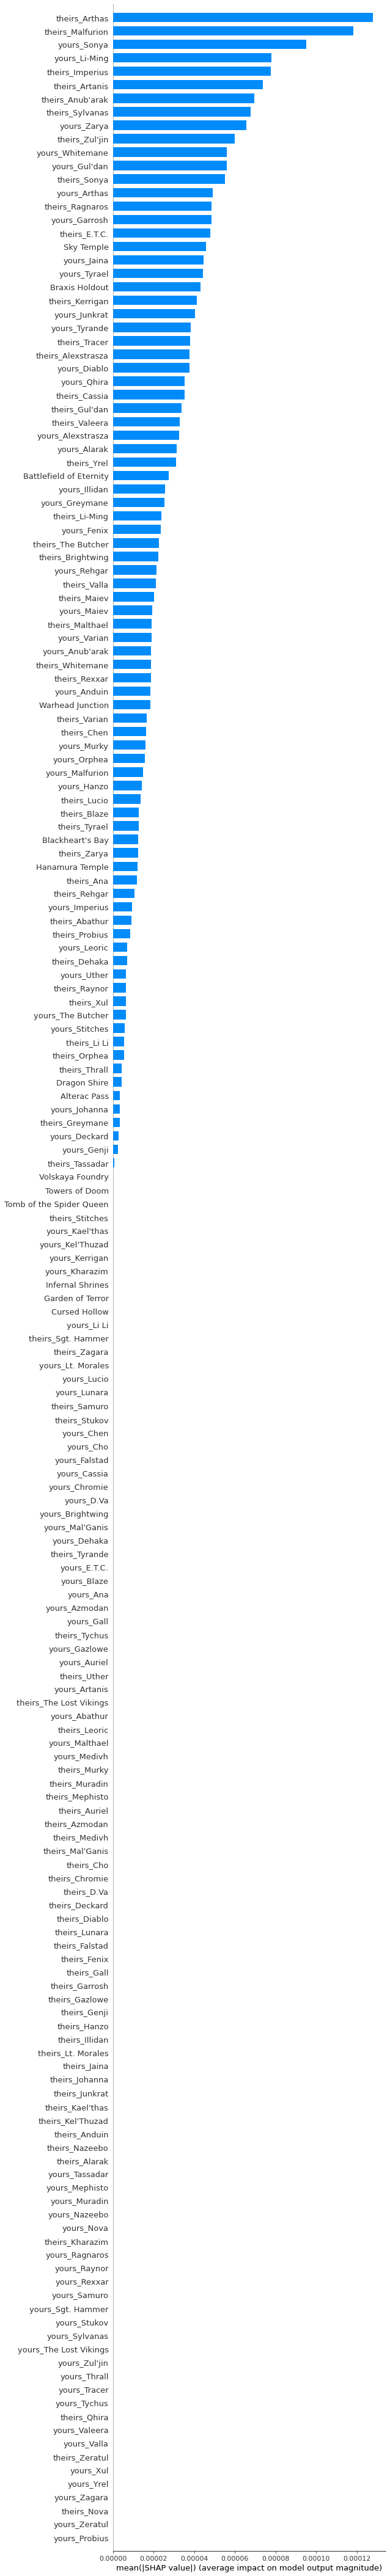

In [231]:
explainer = shap.TreeExplainer(my_model_2)
shap_values = explainer.shap_values(df_trn)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=X_train.shape[1]) #scrollable
#shap.summary_plot(shap_values[:,5:6], X.iloc[:, 5:6])

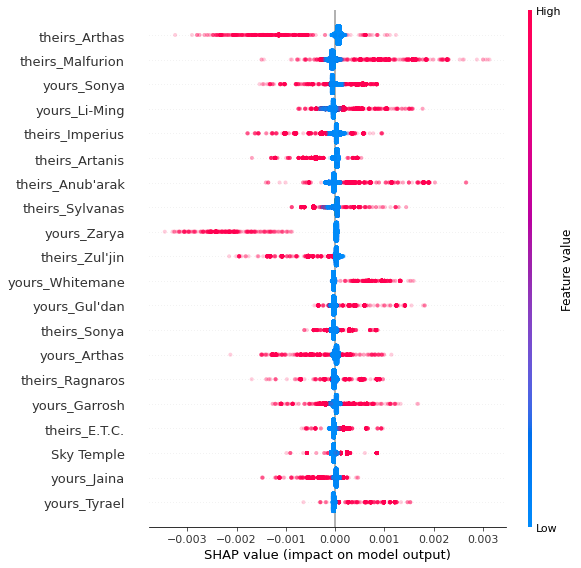

In [232]:
shap.summary_plot(shap_values, df_trn,alpha=0.2)

In [233]:
def hyperParameterTuning_2(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01],
        'max_depth': [3,4,5,6,7,8],
        'min_child_weight': [12,15,18],
        'subsample': [0.5],
        'colsample_bytree': [0.1,0.3,0.6],
        'n_estimators' : [10,11,15]
        #'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor(sample_weight_eval_set = xgb_weights)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [234]:
#hyperParameterTuning_2(X_train, y_train)

In [235]:
my_model_3 = xgboost.XGBRegressor(random_state=0, learning_rate = 0.1, n_estimators = 100, max_depth=10,
                                 min_child_weight=15, subsample=0.5, colsample_bytree=0.1)
%time my_model_3.fit(X_train, y_train, sample_weight_eval_set = xgb_weights, verbose=False) # , early_stopping_rounds=5, eval_set=[(X_valid, y_valid)] # throws assersion error
print_score(my_model_3)

CPU times: user 4.96 s, sys: 17.4 ms, total: 4.98 s
Wall time: 1.35 s
  rmse_trn rmse_val scr_trn scr_val oob_score scr_test
1    0.486    0.502   0.057  -0.007       NaN   -0.013


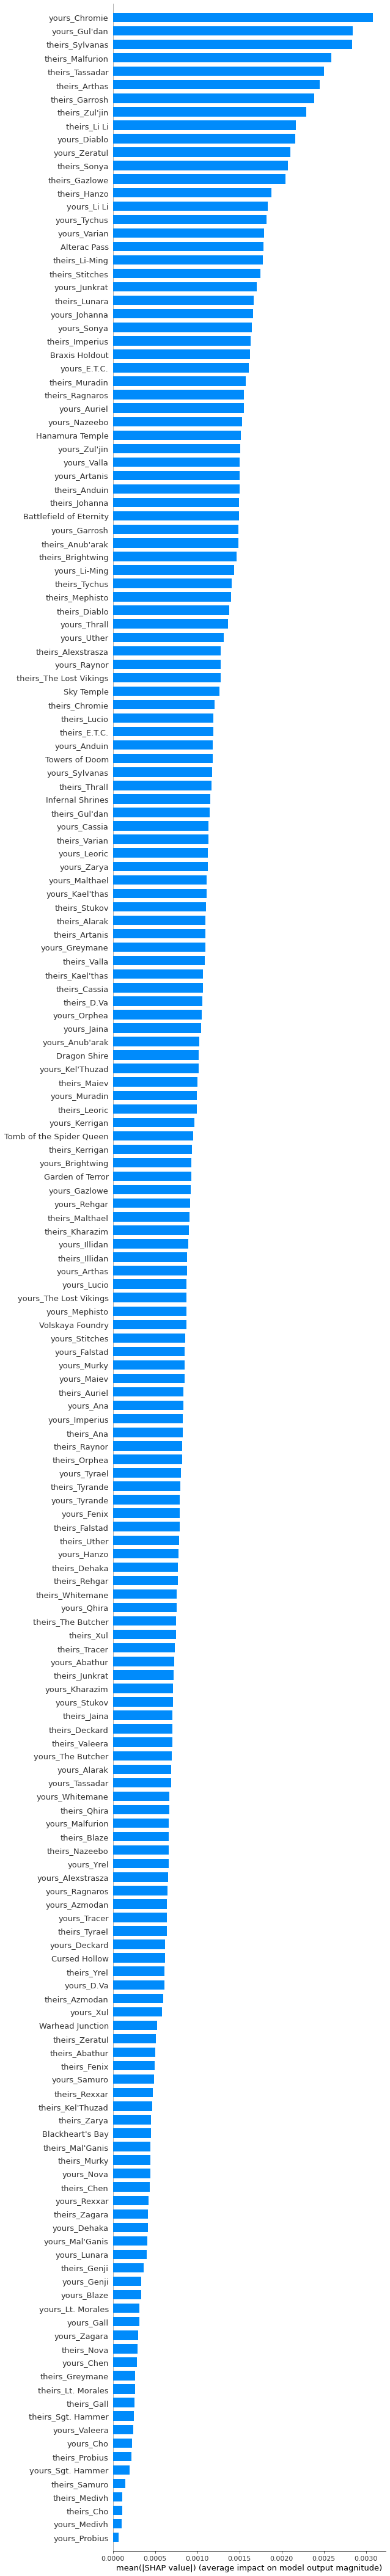

In [236]:
explainer = shap.TreeExplainer(my_model_3)
shap_values = explainer.shap_values(df_trn)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=X_train.shape[1]) #scrollable
#shap.summary_plot(shap_values[:,5:6], X.iloc[:, 5:6])

In [237]:
shap.initjs()

In [238]:
#to visualize single prediction with XGBoost use: shap:  https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
#input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)])
row_input = 1564
#feat_filter = X_train.iloc[row_input,:].columns[(df == 1).any(axis=0)]
features = X_train.iloc[row_input,:]
feature_names = X_train.columns
shap.force_plot(explainer.expected_value, shap_values=shap_values[row_input,:], features=features,feature_names=feature_names,text_rotation=-45)
#How to show the concrete game??? output changes when shap_values[] indexer is changed... but does it input new vals? How to omit zeroes?

In [239]:
def force_plot_pred_filtered(expected_value, input_row):
    pred_shap_values = explainer.shap_values(input_row)[0]
    feature_names = input_row.columns
    features = input_row.iloc[0,:]
    
    shaps_ziped = list(zip(pred_shap_values, features, feature_names))
    shaps_ziped.sort(key=lambda t: t[0], reverse=True)
    
    shaps_filtered = [(s, i, n) for (s, i, n) in shaps_ziped if i > 0]
    rest_shaps_val_total = sum([s for (s, i, n) in shaps_ziped if i == 0])
    
    shaps_filtered.append((rest_shaps_val_total, 0, "Other"))
    
    shap_v_filt = np.array([s for (s, i, n) in shaps_filtered])
    feat_filt = [i for (s, i, n) in shaps_filtered]
    names_filt = [n for (s, i, n) in shaps_filtered]

    return [(n,s) for (s, i, n) in shaps_filtered], shap.force_plot(expected_value, shap_values=shap_v_filt, features=feat_filt, feature_names=names_filt)

In [240]:
hero_one_hot(game_map = game_map, winners = your_team, losers=opponent_tea)

Alterac Pass               False
Battlefield of Eternity    False
Blackheart's Bay           False
Braxis Holdout             False
Cursed Hollow              False
                           ...  
theirs_Yrel                False
theirs_Zagara              False
theirs_Zarya               False
theirs_Zeratul             False
theirs_Zul'jin             False
Length: 188, dtype: boolean

In [241]:
input_row = pd.DataFrame(hero_one_hot(game_map = game_map, winners = your_team, losers=opponent_tea), columns = ["is_present"]).transpose()
#print(input_row)
#vals, plot = force_plot_pred_filtered(explainer.expected_value, input_row)
#print(vals)
#plot

In [242]:
#prediction = my_model_3.predict(input_row)
#print(prediction)

In [243]:
#this doesnt show anything usefull..
#slice_size = int(sample_size / 2)
#shap.dependence_plot("Auriel", shap_values[slice_size:], df_trn[slice_size:], display_features=X_train, x_jitter = 0.15, alpha = 0.2)

# XGBoost model export for API

Save model into a file. Extention will be concidered the type of the model if needed later.

In [244]:
#my_model_3.save_model("exports/model_1.xgboost")

In [245]:
#input_row = pd.DataFrame(hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)).transpose()
#print(input_row)

Then save categories and feature names into separate csv files, becaus emodel does not retain them.

In [246]:
feature_names = dict(enumerate(X_train.columns))
game_map_cats = dict(enumerate(df_mixed['game_map'].cat.categories))
game_type_cats = dict(enumerate(df_mixed['game_type'].cat.categories))
hero_name_cats = dict(enumerate(df_mixed['winnerA'].cat.categories))

NameError: name 'df_mixed' is not defined

In [ ]:
import csv
def save_dict(file_name, dict_obj):
    w = csv.writer(open(file_name, "w+"))
    for key, val in dict_obj.items():
        w.writerow([key, val])

In [ ]:
#save_dict("exports/feature_names.csv", feature_names)
#save_dict("exports/game_map_cats.csv", game_map_cats)
#save_dict("exports/game_type_cats.csv", game_type_cats)
#save_dict("exports/hero_name_cats.csv", hero_name_cats)

In [ ]:
#m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
#gt_names = pd.read_csv("exports/game_type_cats.csv",header=None, index_col=0, squeeze=True).to_dict()

#m_names_swapped = dict([(value, key) for key, value in m_names.items()])
#gt_names_swapped = dict([(value, key) for key, value in gt_names.items()])

Finally, prepair a transform function for API input.

In [ ]:
def hero_hot_transform_xgb(game_map = '', game_type = 'UnrankedDraft', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = m_names_swapped[game_map]
    game_type_index = gt_names_swapped[game_type]        

    new_row = new_row.append(pd.Series([game_map_index, game_type_index], index = ['game_map','game_type']))
    return new_row

In [ ]:
print("DONE")